In [ ]:

# import libraries
import numpy as np

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import copy

import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from scipy.ndimage.measurements import center_of_mass 
import math

In [ ]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
height =28
width=256

In [ ]:

def image_padding(image):
    (h, w) = image.shape[:2]
    #padding on image
    colsPadding = (int(math.ceil((width-w)/2.0)),int(math.floor((width-w)/2.0)))
    rowsPadding = (int(math.ceil((height-h)/2.0)),int(math.floor((height-h)/2.0)))
    #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray_image)

    #updated portion
    #gray_image = 255-gray_image 

    #dataNorm = gray_image / np.max(gray_image)

    
    image_padded = np.lib.pad(image,(rowsPadding,colsPadding),'constant',constant_values=(255,255))
    #plt.imshow(image_padded)
    
    
    cy,cx = center_of_mass(image_padded)

    rows,cols = image_padded.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)
    
    
#def getBestShift(img):
    cy,cx = center_of_mass(image_padded)

    rows,cols = image_padded.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    #return shiftx,shifty
    
    rows,cols = image_padded.shape
    M = np.float32([[1,0,shiftx],[0,1,shifty]])
    shifted = cv2.warpAffine(image_padded,M,(cols,rows))
    #plt.imshow(shifted)
    #print(shifted.shape)
    
    return shifted

In [ ]:
def resize_without_distortion(img):
  def image_resize(image, width, height , inter = cv2.INTER_AREA):
    
    dim=None
    (h, w) = image.shape[:2]
    
    # 1. return original image
    if width is w and height is h:
      print("Same image")
      return image
    
    
    #2.image is small
    elif w<width or  h<height:
        
      wt_ratio=width/float(w)
      ht_ratio=height/float(h)
        
      #too small
      if wt_ratio >=2 and ht_ratio>=2:
        if wt_ratio<ht_ratio:
          #print("Too small 1 case")
          dim=(int(w * wt_ratio), int(h * wt_ratio))
          resized = cv2.resize(image, dim)
                
          #padding on height 
          final_image=image_padding(resized)
          #plt.imshow(final_image)
          return final_image
         
        else:
          #print("Too small 2 case")
          dim=dim = (int(w * ht_ratio), int(h * ht_ratio))
          resized = cv2.resize(image, dim)
                
          #padding on width
          final_image=image_padding(resized)
          #plt.imshow(final_image)
          return final_image
                
            
            #image Padding
      else:
        #print("Small image Padding ")
        #print("Small image Padding ")
        #
        if w<width and h<height:
            #print("1")
            final_image=image_padding(image)
            #plt.imshow(final_image)
            return final_image
        elif w<width and h>height:
            #print("2")
            dim=(w, height)
            resized = cv2.resize(image, dim)
            print(resized.shape)
            final_image=image_padding(resized)
            return final_image
        else:
            #print("3")
            dim=(width, h)
            resized = cv2.resize(image, dim)
            final_image=image_padding(resized)
            return final_image
        #final_image=image_padding(image)
        #plt.imshow(final_image)
        #return final_image
    
    #Large size
    else:
        wt_ratio=w/float(width)
        ht_ratio=h/float(height)
        if wt_ratio>ht_ratio:
            #print("Large image 1 case")
            dim=(int(w /float(wt_ratio)), int(h / float(wt_ratio)))
            resized = cv2.resize(image, dim)
            
            #padding on height 
            final_image=image_padding(resized)
            return final_image
            #plt.imshow(final_image)
        else:
            #print("Large image 2 case")
            dim=(int(w /float(ht_ratio)), int(h / float(ht_ratio)))
            resized = cv2.resize(image, dim)
            
            #padding on height 
            final_image=image_padding(resized)
            return final_image
            #plt.imshow(final_image)

  result_image= image_resize(img, width, height , inter = cv2.INTER_AREA)
  return result_image


In [ ]:
!unzip /content/drive/MyDrive/HWR/dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset/80_003996.png   
 extracting: dataset/80_00430.png    
 extracting: dataset/80_004351.png   
 extracting: dataset/80_004409.png   
 extracting: dataset/80_004413.png   
 extracting: dataset/80_004426.png   
 extracting: dataset/80_004441.png   
 extracting: dataset/80_004494.png   
 extracting: dataset/80_004541.png   
 extracting: dataset/80_00458.png    
 extracting: dataset/80_004678.png   
 extracting: dataset/80_004994.png   
 extracting: dataset/80_00549.png    
 extracting: dataset/80_00657.png    
 extracting: dataset/80_00741.png    
 extracting: dataset/80_00750.png    
 extracting: dataset/80_00837.png    
 extracting: dataset/80_00893.png    
 extracting: dataset/80_00970.png    
 extracting: dataset/80_00981.png    
 extracting: dataset/800_001947.png  
 extracting: dataset/800_002154.png  
 extracting: dataset/800_00355.png   
 extracting: dataset/800_003747.png  
 extracting: dataset/800_004296.png  

In [ ]:
filelist = glob.glob('/content/dataset/*.png')

In [ ]:
img_count=len(filelist)

In [ ]:
img_count

50000

In [ ]:
def image_preprocessing(filelist):
    i=0
    imagesOcc   = torch.zeros(img_count,1,28,256)
    imagesNoOcc = torch.zeros(img_count,1,28,256)
    for fname in filelist:
        #print(fname)
        img=cv2.imread(fname)
        gray_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        gray_image=255-gray_image

        #img_resize = cv2.resize(255-gray_image, (224,56)) 
        Noocclusion_resized=resize_without_distortion(gray_image)
        #occluded_resized=resize_without_distortion(occluded)

        occluded = copy.deepcopy( gray_image )
        i1 = np.random.choice(np.arange(10,18))
        i2 = np.random.choice(np.arange(2,3))
        occluded[i1:i1+i2,] = 0

        occluded_resized=resize_without_distortion(occluded)
        
        NoOcc_dataNorm = Noocclusion_resized / np.max(Noocclusion_resized)
        Occ_dataNorm = occluded_resized / np.max(occluded_resized)


        # convert to tensor
        NoOcc_dataT= torch.tensor( NoOcc_dataNorm ).float()
        Occ_dataT= torch.tensor( Occ_dataNorm ).float()
        
        #img=NoOcc_dataT
        
        imagesNoOcc[i,:,:,:]=torch.Tensor(NoOcc_dataT).view(1,28,256)
        
        
        #occluded = copy.deepcopy( img )
        #i1 = np.random.choice(np.arange(10,18))
        #i2 = np.random.choice(np.arange(2,3))
        #occluded[i1:i1+i2,] = 0
      
    
        imagesOcc[i,:,:,:] = torch.Tensor(Occ_dataT).view(1,28,256)
        i=i+1
    return imagesNoOcc,imagesOcc

imagesNoOcc,imagesOcc=image_preprocessing(filelist)

In [ ]:
imagesNoOcc.shape

torch.Size([50000, 1, 28, 256])

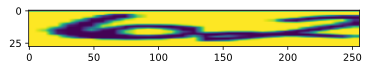

In [ ]:
plt.imshow(np.squeeze( imagesNoOcc[100,:,:] ))

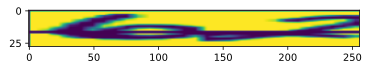

In [ ]:
plt.imshow(np.squeeze( imagesOcc[100,:,:] ))

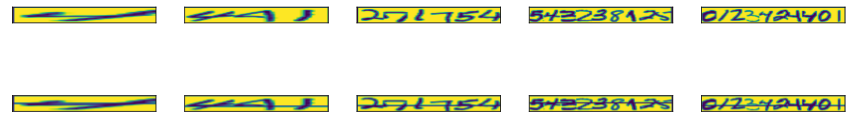

In [ ]:
fig,ax = plt.subplots(2,5,figsize=(15,3))

for i in range(5):
    
  whichpic = np.random.randint(img_count)
    
  I1 = torch.squeeze(imagesNoOcc[whichpic,:,:] ).detach()
  I2 = torch.squeeze( imagesOcc[whichpic,:,:] ).detach()
  
    
  ax[0,i].imshow(I1)
  ax[0,i].set_xticks([]), ax[0,i].set_yticks([])
  
  ax[1,i].imshow(I2 )
  ax[1,i].set_xticks([]), ax[1,i].set_yticks([])

plt.show()

In [ ]:

# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # encoding layer
      self.enc = nn.Sequential(
          nn.Conv2d(1, 16, 3, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(16, 32, 3, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(32, 64, 7),

   
          )
      
      # decoding layer
      self.dec = nn.Sequential(
          nn.ConvTranspose2d(64, 32, 7),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
          nn.ReLU(),
          nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
          nn.Sigmoid()
          )
      
    def forward(self,x):
      return self.dec( self.enc(x) )
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# test the model with one batch
net,lossfun,optimizer = makeTheNet()

In [ ]:
from torchsummary import summary

In [ ]:
summary(net.to(device), (1, 28, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 14, 128]             160
              ReLU-2          [-1, 16, 14, 128]               0
            Conv2d-3            [-1, 32, 7, 64]           4,640
              ReLU-4            [-1, 32, 7, 64]               0
            Conv2d-5            [-1, 64, 1, 58]         100,416
   ConvTranspose2d-6            [-1, 32, 7, 64]         100,384
              ReLU-7            [-1, 32, 7, 64]               0
   ConvTranspose2d-8          [-1, 16, 14, 128]           4,624
              ReLU-9          [-1, 16, 14, 128]               0
  ConvTranspose2d-10           [-1, 1, 28, 256]             145
          Sigmoid-11           [-1, 1, 28, 256]               0
Total params: 210,369
Trainable params: 210,369
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/

 
torch.Size([5, 1, 28, 256])
torch.Size([50000, 1, 28, 256])


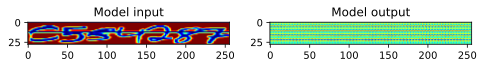

In [ ]:
yHat = net(imagesOcc[:5,:,:,:])

# check size of output
print(' ')
print(yHat.shape)
print(imagesOcc.shape)


# let's see how they look
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(torch.squeeze(imagesOcc[0,0,:,:]).detach(),cmap='jet')
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model output')

plt.show()

In [ ]:
yHat.summary()

AttributeError: ignored

In [ ]:

# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 1000
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

   # model
  net.to(device)


  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):
      
    print("Epoch no: ",epochi)
      
    # pick a set of images at random
    pics2use = np.random.choice(img_count,size=32,replace=False)

    # get the input (has occlusions) and the target (no occlusions)
    X = imagesOcc[pics2use,:,:,:]
    Y = imagesNoOcc[pics2use,:,:,:]

    # data
    X=X.to(device)
    Y=Y.to(device)

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,Y)
    losses[epochi] = loss.item()
    

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net,Y,yHat

# test the model on a bit of data
losses,net,Y,yHat = function2trainTheModel()


Epoch no:  0
Epoch no:  1
Epoch no:  2
Epoch no:  3
Epoch no:  4
Epoch no:  5
Epoch no:  6
Epoch no:  7
Epoch no:  8
Epoch no:  9
Epoch no:  10
Epoch no:  11
Epoch no:  12
Epoch no:  13
Epoch no:  14
Epoch no:  15
Epoch no:  16
Epoch no:  17
Epoch no:  18
Epoch no:  19
Epoch no:  20
Epoch no:  21
Epoch no:  22
Epoch no:  23
Epoch no:  24
Epoch no:  25
Epoch no:  26
Epoch no:  27
Epoch no:  28
Epoch no:  29
Epoch no:  30
Epoch no:  31
Epoch no:  32
Epoch no:  33
Epoch no:  34
Epoch no:  35
Epoch no:  36
Epoch no:  37
Epoch no:  38
Epoch no:  39
Epoch no:  40
Epoch no:  41
Epoch no:  42
Epoch no:  43
Epoch no:  44
Epoch no:  45
Epoch no:  46
Epoch no:  47
Epoch no:  48
Epoch no:  49
Epoch no:  50
Epoch no:  51
Epoch no:  52
Epoch no:  53
Epoch no:  54
Epoch no:  55
Epoch no:  56
Epoch no:  57
Epoch no:  58
Epoch no:  59
Epoch no:  60
Epoch no:  61
Epoch no:  62
Epoch no:  63
Epoch no:  64
Epoch no:  65
Epoch no:  66
Epoch no:  67
Epoch no:  68
Epoch no:  69
Epoch no:  70
Epoch no:  71
Ep

In [ ]:
pwd

'/content'

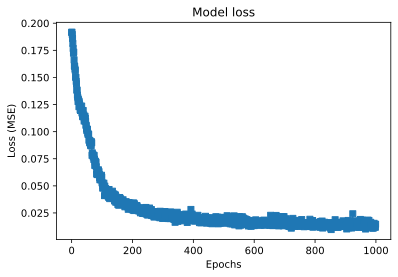

In [ ]:
file='/content/drive/MyDrive/HWR/model.pth'
torch.save(net.state_dict(), file)

plt.plot(losses,'s-',label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')

plt.show()

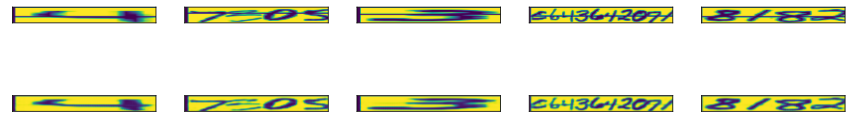

In [ ]:

pics2use = np.random.choice(img_count,size=32,replace=False)
X = imagesOcc[pics2use,:,:,:].to(device)
yHat = net(X)

fig,ax = plt.subplots(2,5,figsize=(15,3))
for i in range(5):
    
  #whichpic = np.random.randint(img_count)
    
  I1 = torch.squeeze(X[i,:,:] ).detach().cpu()
  I2 = torch.squeeze( yHat[i,:,:] ).detach().cpu()
  
    
  ax[0,i].imshow(I1)
  ax[0,i].set_xticks([]), ax[0,i].set_yticks([])
  
  ax[1,i].imshow(I2 )
  ax[1,i].set_xticks([]), ax[1,i].set_yticks([])

plt.show()

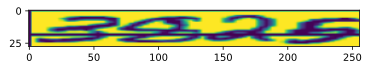

In [ ]:
plt.imshow(torch.squeeze( X[10,:,:] ).cpu())

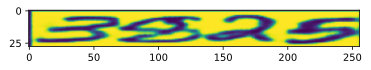

In [ ]:
plt.imshow(torch.squeeze( yHat[10,:,:] ).detach().cpu())

In [ ]:
net.load_state_dict(torch.load('/content/drive/MyDrive/HWR/model.pth'))

<All keys matched successfully>

In [ ]:
#Inference Model
image=cv2.imread('/content/drive/MyDrive/HWR/sample.png')

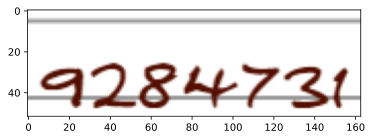

In [ ]:
plt.imshow(image)

In [ ]:
image.shape

(52, 163, 3)

In [ ]:
gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
gray_image=255-gray_image

In [ ]:
gray_image.shape

(52, 163)

In [ ]:
resized=resize_without_distortion(gray_image)

(28, 163)


In [ ]:
resized.shape

(28, 256)

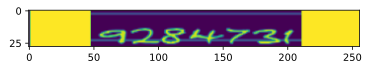

In [ ]:
plt.imshow(resized)

In [ ]:
dataNorm = resized / np.max(resized)

In [ ]:
 # convert to tensor
dataT= torch.tensor( dataNorm ).float()

In [ ]:
images_inference = torch.zeros(1,1,28,256)

In [ ]:
images_inference[0,:,:,:]=torch.Tensor(dataT).view(1,28,256)

In [ ]:
images_inference=images_inference.to(device)

In [ ]:
yHat_inference = net(images_inference).to(device)

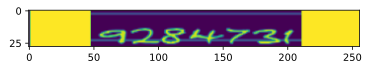

In [ ]:
plt.imshow(torch.squeeze( images_inference[0,:,:] ).cpu())

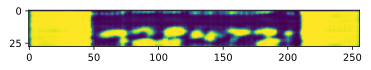

In [ ]:
plt.imshow(torch.squeeze( yHat_inference[0,:,:] ).detach().cpu())